In [12]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, List
import operator
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, AIMessage, ChatMessage
from langchain.chains import LLMChain
from langchain.prompts import PromptTemplate
from langchain.llms import OpenAI

In [13]:
import os
import re
from typing import Dict, List, Any
from langchain.chat_models import ChatOpenAI
from langchain.schema import SystemMessage, HumanMessage
from langgraph.graph import StateGraph, END
from typing_extensions import TypedDict

In [14]:
# Retail Inventory Management System using LangGraph
import os
import re
import time
from typing import TypedDict, Annotated, List, Dict, Any
from fpdf import FPDF

In [15]:
from dotenv import load_dotenv
_ = load_dotenv()

In [16]:
# LangGraph imports
from langgraph.graph import StateGraph, END
from langgraph.checkpoint.sqlite import SqliteSaver
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, AIMessage, ChatMessage
from langchain_openai import ChatOpenAI
from langgraph.checkpoint.sqlite import SqliteSaver

# Setup memory for checkpointing
memory = SqliteSaver.from_conn_string(":memory:")


In [17]:
# Set up OpenAI client
api_key = os.environ.get("OPENAI_API_KEY")
if not api_key:
    raise ValueError("The OPENAI_API_KEY environment variable is not set.")

# Initialize the model
model = ChatOpenAI(model="gpt-4o-mini", temperature=0, api_key=api_key)
# System prompts for each agent
CUSTOMER_PROMPT = """You are a customer representative communicating inventory management requirements to a project manager.
Your retail business needs an inventory management system that tracks inventory levels in real-time, predicts stock shortages, and automates reordering processes."""

PROJECT_MANAGER_PROMPT = """You are a project manager responsible for creating and managing a project plan for an Inventory Management System.
Your role is to coordinate with engineers, ensure timely delivery, and manage proper documentation.
Based on the customer requirements, create a project plan that outlines how the system will be built using the Waterfall methodology."""

REQUIREMENT_ENGINEER_PROMPT = """You are a requirements engineer tasked with creating detailed requirements for an Inventory Management System.
Based on the project plan, list detailed use cases and requirements with unique numbers for each.
Create at least 10 use cases covering all aspects of the system.
Calculate the effort required as follows:
- Work = total number of requirements
- Productivity rate = 5 requirements per day
- Effort = Work / Productivity
Include tasks for requirement reviews and potential rework."""

SYSTEM_ENGINEER_PROMPT = """You are a system engineer responsible for creating a detailed design document based on the requirements.
Include example code snippets for each design element.
Calculate the effort required as follows:
- Work = total number of pages in the design document
- Productivity rate = 5 pages per day
- Effort = Work / Productivity
Include tasks for design reviews and potential rework."""

SOFTWARE_ENGINEER_PROMPT = """You are a software engineer writing complete source code for the Inventory Management System.
Based on the design document, implement the system with functional code.
Calculate the effort required as follows:
- Work = total number of lines of code (SLOC)
- Productivity rate = 50 SLOC per day
- Effort = Work / Productivity
Include tasks for code reviews and potential refactoring."""

TEST_ENGINEER_PROMPT = """You are a test engineer creating and executing test cases for the Inventory Management System.
Based on requirements, design, and implementation, develop a comprehensive test plan.
Calculate the effort required as follows:
- Work = total number of test cases
- Productivity rate = 2 test cases per day
- Effort = Work / Productivity
Include tasks for test plan reviews and potential updates."""

DOCUMENTATION_ENGINEER_PROMPT = """You are a documentation engineer creating user documentation and training materials.
Based on the requirements, design, and implementation, create complete documentation.
Calculate the effort required as follows:
- Work = total number of documentation pages
- Productivity rate = 3 pages per day
- Effort = Work / Productivity
Include tasks for documentation reviews and potential updates."""

FINAL_REPORT_PROMPT = """You are a project manager completing a final project report.
Summarize all phases of the project, including work done, effort expended, and outcomes achieved.
Provide a comprehensive project summary for the customer."""

# When defining your state class, rename the fields to avoid conflicts with node names
class WaterfallState(TypedDict):
    customer_req: str  # Changed from customer_requirements
    project_plan_doc: str  # Changed from project_plan
    requirements_document: str  # Changed from requirements_doc
    design_document: str  # Changed from design_doc
    source_code_impl: str  # Changed from source_code
    test_plan_doc: str  # Changed from test_plan
    documentation_doc: str  # Changed from documentation
    final_report_doc: str  # Changed from final_report
    current_phase: str
    phase_outputs: Dict[str, str]
    conversation_history: List[Dict[str, str]]
    pdf_path: str
    metrics: Dict[str, Any]
    analysis_summary: str

# Then update your node function to use these new state keys
def customer_requirements_node(state: WaterfallState):
    """Initial node where customer requirements are captured"""
    messages = [
        SystemMessage(content=CUSTOMER_PROMPT),
        HumanMessage(content="Please describe your requirements for the Inventory Management System")
    ]
    response = model.invoke(messages)
    
    # Store in conversation history
    conversation = state.get("conversation_history", [])
    conversation.append({
        "role": "Customer_Proxy",
        "content": response.content
    })
    
    return {
        "customer_req": response.content,  # Changed key name
        "current_phase": "requirements_gathering",
        "conversation_history": conversation,
        "phase_outputs": {"Customer_Proxy": response.content}
    }

# Similarly update all other node functions to use the new state keys
def project_plan_node(state: WaterfallState):
    """Project manager creates the initial project plan"""
    messages = [
        SystemMessage(content=PROJECT_MANAGER_PROMPT),
        HumanMessage(content=f"Based on the following customer requirements, create a project plan for the Inventory Management System:\n\n{state['customer_req']}")  # Updated key
    ]
    response = model.invoke(messages)
    
   # Store in conversation history
    conversation = state.get("conversation_history", [])
    conversation.append({
        "role": "Project_Manager",
        "content": response.content
    })
    
    phase_outputs = state.get("phase_outputs", {})
    phase_outputs["Project_Manager"] = response.content
    
    return {
        "project_plan_doc": response.content,  # Changed key name
        "current_phase": "project_planning",
        "conversation_history": conversation,
        "phase_outputs": phase_outputs
    }


def requirements_doc_node(state: WaterfallState):
    """Requirements engineer creates the requirements document"""
    messages = [
        SystemMessage(content=REQUIREMENT_ENGINEER_PROMPT),
        HumanMessage(content=f"Based on the following project plan, create detailed requirements for the Inventory Management System:\n\n{state['project_plan_doc']}")  # Updated key
    ]
    response = model.invoke(messages)
    
    # Store in conversation history
    conversation = state.get("conversation_history", [])
    conversation.append({
        "role": "Requirement_Engineer",
        "content": response.content
    })
    
    phase_outputs = state.get("phase_outputs", {})
    phase_outputs["Requirement_Engineer"] = response.content
    
    return {
        "requirements_document": response.content,  # Updated key
        "current_phase": "requirements_engineering",
        "conversation_history": conversation,
        "phase_outputs": phase_outputs
    }

def design_doc_node(state: WaterfallState):
    """System engineer creates the design document"""
    messages = [
        SystemMessage(content=SYSTEM_ENGINEER_PROMPT),
        HumanMessage(content=f"Based on the following requirements document, create a detailed design document for the Inventory Management System:\n\n{state['requirements_document']}")  # Updated key
    ]
    response = model.invoke(messages)
    
    # Store in conversation history
    conversation = state.get("conversation_history", [])
    conversation.append({
        "role": "System_Engineer",
        "content": response.content
    })
    
    phase_outputs = state.get("phase_outputs", {})
    phase_outputs["System_Engineer"] = response.content
    
    return {
        "design_document": response.content,  # Updated key
        "current_phase": "system_design",
        "conversation_history": conversation,
        "phase_outputs": phase_outputs
    }

def source_code_node(state: WaterfallState):
    """Software engineer creates the source code"""
    messages = [
        SystemMessage(content=SOFTWARE_ENGINEER_PROMPT),
        HumanMessage(content=f"Based on the following design document, create source code for the Inventory Management System:\n\n{state['design_document']}")  # Updated key
    ]
    response = model.invoke(messages)
    
    # Store in conversation history
    conversation = state.get("conversation_history", [])
    conversation.append({
        "role": "Software_Engineer",
        "content": response.content
    })
    
    phase_outputs = state.get("phase_outputs", {})
    phase_outputs["Software_Engineer"] = response.content
    
    return {
        "source_code_impl": response.content,  # Updated key
        "current_phase": "implementation",
        "conversation_history": conversation,
        "phase_outputs": phase_outputs
    }

def test_plan_node(state: WaterfallState):
    """Test engineer creates and executes the test plan"""
    messages = [
        SystemMessage(content=TEST_ENGINEER_PROMPT),
        HumanMessage(content=f"Based on the following requirements, design, and implementation, create a test plan for the Inventory Management System:\n\nRequirements:\n{state['requirements_document']}\n\nDesign:\n{state['design_document']}\n\nImplementation:\n{state['source_code_impl']}")  # Updated keys
    ]
    response = model.invoke(messages)
    
    # Store in conversation history
    conversation = state.get("conversation_history", [])
    conversation.append({
        "role": "Test_Engineer",
        "content": response.content
    })
    
    phase_outputs = state.get("phase_outputs", {})
    phase_outputs["Test_Engineer"] = response.content
    
    return {
        "test_plan_doc": response.content,  # Updated key
        "current_phase": "testing",
        "conversation_history": conversation,
        "phase_outputs": phase_outputs
    }

def documentation_node(state: WaterfallState):
    """Documentation engineer creates user documentation"""
    messages = [
        SystemMessage(content=DOCUMENTATION_ENGINEER_PROMPT),
        HumanMessage(content=f"Based on the following requirements, design, implementation, and test plan, create documentation for the Inventory Management System:\n\nRequirements:\n{state['requirements_document']}\n\nDesign:\n{state['design_document']}\n\nImplementation:\n{state['source_code_impl']}\n\nTest Plan:\n{state['test_plan_doc']}")  # Updated keys
    ]
    response = model.invoke(messages)
    
    # Store in conversation history
    conversation = state.get("conversation_history", [])
    conversation.append({
        "role": "Documentation_Engineer",
        "content": response.content
    })
    
    phase_outputs = state.get("phase_outputs", {})
    phase_outputs["Documentation_Engineer"] = response.content
    
    return {
        "documentation_doc": response.content,  # Updated key
        "current_phase": "documentation",
        "conversation_history": conversation,
        "phase_outputs": phase_outputs
    }

def final_report_node(state: WaterfallState):
    """Project manager creates the final report"""
    messages = [
        SystemMessage(content=FINAL_REPORT_PROMPT),
        HumanMessage(content=f"""Please create a final project report summarizing all phases of the Inventory Management System project.
        
Customer Requirements:
{state['customer_req']}

Requirements Document:
{state['requirements_document']}

Design Document:
{state['design_document']}

Implementation:
{state['source_code_impl']}

Test Plan:
{state['test_plan_doc']}

Documentation:
{state['documentation_doc']}
        """)  # Updated all keys
    ]
    response = model.invoke(messages)
    
    # Store in conversation history
    conversation = state.get("conversation_history", [])
    conversation.append({
        "role": "Project_Manager",
        "content": response.content
    })
    
    phase_outputs = state.get("phase_outputs", {})
    phase_outputs["Project_Manager_Final"] = response.content
    
    return {
        "final_report_doc": response.content,  # Updated key
        "current_phase": "project_completion",
        "conversation_history": conversation,
        "phase_outputs": phase_outputs
    }
def generate_pdf_node(state: WaterfallState):
    """Generate a PDF report of the entire project"""
    try:
        # Function to clean Unicode characters
        def clean_text(text):
            if not isinstance(text, str):
                return str(text)
            
            # Dictionary of problematic characters and their replacements
            replacements = {
                '\u2018': "'",  # Left single quote
                '\u2019': "'",  # Right single quote
                '\u201c': '"',  # Left double quote
                '\u201d': '"',  # Right double quote
                '\u2013': '-',  # En dash
                '\u2014': '--', # Em dash
                '\u2026': '...', # Ellipsis
                '\u00a0': ' ',  # Non-breaking space
                '\u2022': '*',  # Bullet point
                '\u00b7': '*',  # Middle dot
                '\u2023': '>', # Triangular bullet
                '\u25e6': 'o', # White bullet
                '\u2043': '-', # Hyphen bullet
                '\u00ae': '(R)', # Registered trademark
                '\u00a9': '(C)', # Copyright
                '\u2122': '(TM)' # Trademark
            }
            
            for char, replacement in replacements.items():
                text = text.replace(char, replacement)
                
            return text
        
        # Initialize PDF
        pdf = FPDF(format='A4')
        pdf.add_page()
        
        # Set font for the document
        pdf.set_font("Arial", "B", 16)
        
        # Add title
        pdf.cell(190, 10, "Retail Inventory Management System", ln=True, align='C')
        pdf.cell(190, 10, "Waterfall Model Implementation", ln=True, align='C')
        
        # Add date
        pdf.set_font("Arial", "", 10)
        date_str = time.strftime("%Y-%m-%d %H:%M:%S")
        pdf.cell(190, 10, f"Generated on: {date_str}", ln=True, align='R')
        
        # Add separator line
        pdf.line(10, pdf.get_y(), 200, pdf.get_y())
        pdf.ln(10)
        
        # Table of Contents
        pdf.set_font("Arial", "B", 14)
        pdf.cell(190, 10, "Table of Contents", ln=True)
        pdf.set_font("Arial", "", 12)
        
        # List phases in the Table of Contents
        phases = [
            "1. Customer Requirements",
            "2. Project Planning",
            "3. Requirements Engineering",
            "4. System Design",
            "5. Implementation",
            "6. Testing",
            "7. Documentation",
            "8. Project Completion"
        ]
        
        for phase in phases:
            pdf.cell(190, 8, phase, ln=True)
        
        # Add each phase's output to the PDF
        phase_outputs = state.get("phase_outputs", {})
        
        # Customer Requirements
        pdf.add_page()
        pdf.set_font("Arial", "B", 14)
        pdf.cell(190, 10, "1. Customer Requirements", ln=True)
        pdf.line(10, pdf.get_y(), 200, pdf.get_y())
        pdf.ln(5)
        
        pdf.set_font("Arial", "", 11)
        if "Customer_Proxy" in phase_outputs:
            formatted_text = clean_text(phase_outputs["Customer_Proxy"])
            formatted_text = formatted_text.replace('\n', ' ').strip()
            pdf.multi_cell(190, 7, formatted_text)
        
        # Project Planning
        pdf.add_page()
        pdf.set_font("Arial", "B", 14)
        pdf.cell(190, 10, "2. Project Planning", ln=True)
        pdf.line(10, pdf.get_y(), 200, pdf.get_y())
        pdf.ln(5)
        
        pdf.set_font("Arial", "", 11)
        if "Project_Manager" in phase_outputs:
            formatted_text = clean_text(phase_outputs["Project_Manager"])
            formatted_text = formatted_text.replace('\n', ' ').strip()
            pdf.multi_cell(190, 7, formatted_text)
        
        # Requirements Engineering
        pdf.add_page()
        pdf.set_font("Arial", "B", 14)
        pdf.cell(190, 10, "3. Requirements Engineering", ln=True)
        pdf.line(10, pdf.get_y(), 200, pdf.get_y())
        pdf.ln(5)
        
        pdf.set_font("Arial", "", 11)
        if "Requirement_Engineer" in phase_outputs:
            formatted_text = clean_text(phase_outputs["Requirement_Engineer"])
            formatted_text = formatted_text.replace('\n', ' ').strip()
            pdf.multi_cell(190, 7, formatted_text)
        
        # System Design
        pdf.add_page()
        pdf.set_font("Arial", "B", 14)
        pdf.cell(190, 10, "4. System Design", ln=True)
        pdf.line(10, pdf.get_y(), 200, pdf.get_y())
        pdf.ln(5)
        
        pdf.set_font("Arial", "", 11)
        if "System_Engineer" in phase_outputs:
            formatted_text = clean_text(phase_outputs["System_Engineer"])
            formatted_text = formatted_text.replace('\n', ' ').strip()
            pdf.multi_cell(190, 7, formatted_text)
        
        # Implementation
        pdf.add_page()
        pdf.set_font("Arial", "B", 14)
        pdf.cell(190, 10, "5. Implementation", ln=True)
        pdf.line(10, pdf.get_y(), 200, pdf.get_y())
        pdf.ln(5)
        
        pdf.set_font("Arial", "", 11)
        if "Software_Engineer" in phase_outputs:
            formatted_text = clean_text(phase_outputs["Software_Engineer"])
            formatted_text = formatted_text.replace('\n', ' ').strip()
            pdf.multi_cell(190, 7, formatted_text)
        
        # Testing
        pdf.add_page()
        pdf.set_font("Arial", "B", 14)
        pdf.cell(190, 10, "6. Testing", ln=True)
        pdf.line(10, pdf.get_y(), 200, pdf.get_y())
        pdf.ln(5)
        
        pdf.set_font("Arial", "", 11)
        if "Test_Engineer" in phase_outputs:
            formatted_text = clean_text(phase_outputs["Test_Engineer"])
            formatted_text = formatted_text.replace('\n', ' ').strip()
            pdf.multi_cell(190, 7, formatted_text)
        
        # Documentation
        pdf.add_page()
        pdf.set_font("Arial", "B", 14)
        pdf.cell(190, 10, "7. Documentation", ln=True)
        pdf.line(10, pdf.get_y(), 200, pdf.get_y())
        pdf.ln(5)
        
        pdf.set_font("Arial", "", 11)
        if "Documentation_Engineer" in phase_outputs:
            formatted_text = clean_text(phase_outputs["Documentation_Engineer"])
            formatted_text = formatted_text.replace('\n', ' ').strip()
            pdf.multi_cell(190, 7, formatted_text)
        
        # Project Completion
        pdf.add_page()
        pdf.set_font("Arial", "B", 14)
        pdf.cell(190, 10, "8. Project Completion", ln=True)
        pdf.line(10, pdf.get_y(), 200, pdf.get_y())
        pdf.ln(5)
        
        pdf.set_font("Arial", "", 11)
        if "Project_Manager_Final" in phase_outputs:
            formatted_text = clean_text(phase_outputs["Project_Manager_Final"])
            formatted_text = formatted_text.replace('\n', ' ').strip()
            pdf.multi_cell(190, 7, formatted_text)
        
        # Add a summary page
        pdf.add_page()
        pdf.set_font("Arial", "B", 14)
        pdf.cell(190, 10, "Waterfall Project Summary", ln=True)
        pdf.line(10, pdf.get_y(), 200, pdf.get_y())
        pdf.ln(5)
        
        # Define the waterfall phases
        phases = [
            "Requirements Gathering and Analysis",
            "System Design",
            "Implementation",
            "Testing",
            "Deployment",
            "Maintenance"
        ]
        
        # Primary agent responsible for each phase
        phase_owners = [
            "Requirement Engineer",
            "System Engineer",
            "Software Engineer",
            "Test Engineer",
            "Project Manager",
            "Project Manager"
        ]
        
        # Create a table for the phases and their statuses
        pdf.set_font("Arial", "B", 11)
        pdf.cell(95, 10, "Waterfall Phase", 1, 0, 'C')
        pdf.cell(95, 10, "Primary Agent", 1, 1, 'C')
        
        # Add each phase and its status
        pdf.set_font("Arial", "", 10)
        for phase, agent in zip(phases, phase_owners):
            pdf.cell(95, 10, phase, 1, 0)
            pdf.cell(95, 10, agent, 1, 1)
        
        # Add conclusion
        pdf.ln(10)
        pdf.set_font("Arial", "B", 12)
        pdf.cell(190, 10, "Project Conclusion", ln=True)
        
        pdf.set_font("Arial", "", 10)
        conclusion_text = """
The Retail Inventory Management System project has been successfully completed following the Waterfall 
methodology. All phases from requirements gathering to deployment have been executed according 
to plan, with each agent contributing their expertise at the appropriate stage.

The project demonstrates the effective application of the Waterfall model for structured 
software development, with clear handoffs between project phases and specialized team members.
        """
        
        # Clean and add the conclusion text
        conclusion_text = clean_text(conclusion_text)
        pdf.multi_cell(190, 7, conclusion_text)
        
        # Save the PDF
        output_path = "retail_inventory_project_Lang.pdf"
        pdf.output(output_path)
        
        print(f"PDF Report generated successfully at: {output_path}")
        
        return {
            "pdf_path": output_path,
            "current_phase": "completed"
        }
        
    except Exception as e:
        print(f"Error generating PDF: {e}")
        return {
            "pdf_path": "error_generating_pdf",
            "current_phase": "completed"
        }

def extract_metrics_node(state: WaterfallState):
    """Extract metrics for analysis report"""
    # Define functions to extract information
    def extract_count(text, term, default=0):
        """Extract a count of items (requirements, pages, etc.) from text"""
        if not text:
            return default
        
        # Look for patterns like "10 requirements" or "15 pages"
        patterns = [
            rf"(\d+)\s+{term}s?",  # e.g., "10 requirements"
            rf"(\d+)\s+total\s+{term}s?",  # e.g., "10 total requirements"
            rf"total\s+of\s+(\d+)\s+{term}s?",  # e.g., "total of 10 requirements"
        ]
        
        for pattern in patterns:
            matches = re.findall(pattern, text, re.IGNORECASE)
            if matches:
                return int(matches[0])
        
        return default

    def extract_effort(text):
        """Extract effort information from text"""
        if not text:
            return "Not specified"
        
        # Look for effort statements
        effort_patterns = [
            r"effort\s*=\s*([^.]+)",  # e.g., "effort = 2 days"
            r"estimated\s+effort\s*:?\s*([^.]+)",  # e.g., "estimated effort: 2 days"
            r"effort\s+estimate\s*:?\s*([^.]+)",  # e.g., "effort estimate: 2 days"
            r"will\s+take\s+([^.]+)",  # e.g., "will take 2 days"
        ]
        
        for pattern in effort_patterns:
            matches = re.findall(pattern, text, re.IGNORECASE)
            if matches:
                return matches[0].strip()
        
        return "Not specified"

    def extract_days(text, default=0):
        """Extract the number of days from text"""
        if not text:
            return default
        
        day_patterns = [
            r"(\d+)\s+days?",  # e.g., "2 days"
            r"(\d+)\s+working\s+days?",  # e.g., "2 working days"
            r"duration\s*[=:]\s*(\d+)\s+days?",  # e.g., "duration = 2 days"
        ]
        
        for pattern in day_patterns:
            matches = re.findall(pattern, text, re.IGNORECASE)
            if matches:
                return int(matches[0])
        
        # If we find weeks, convert to days (5 days per week)
        week_matches = re.findall(r"(\d+)\s+weeks?", text, re.IGNORECASE)
        if week_matches:
            return int(week_matches[0]) * 5
        
        # If we find months, convert to days (20 days per month)
        month_matches = re.findall(r"(\d+)\s+months?", text, re.IGNORECASE)
        if month_matches:
            return int(month_matches[0]) * 20
        
        return default
    
    # Extract metrics from each phase
    phase_outputs = state.get("phase_outputs", {})
    
    metrics = {
        "requirements": {
            "count": extract_count(phase_outputs.get("Requirement_Engineer", ""), "requirement", default=10),
            "effort": extract_effort(phase_outputs.get("Requirement_Engineer", "")),
            "days": extract_days(phase_outputs.get("Requirement_Engineer", ""), default=2)
        },
        "design": {
            "count": extract_count(phase_outputs.get("System_Engineer", ""), "page", default=15),
            "effort": extract_effort(phase_outputs.get("System_Engineer", "")),
            "days": extract_days(phase_outputs.get("System_Engineer", ""), default=3)
        },
        "development": {
            "count": extract_count(phase_outputs.get("Software_Engineer", ""), "line", default=500),
            "effort": extract_effort(phase_outputs.get("Software_Engineer", "")),
            "days": extract_days(phase_outputs.get("Software_Engineer", ""), default=10)
        },
        "testing": {
            "count": extract_count(phase_outputs.get("Test_Engineer", ""), "test case", default=20),
            "effort": extract_effort(phase_outputs.get("Test_Engineer", "")),
            "days": extract_days(phase_outputs.get("Test_Engineer", ""), default=10)
        },
        "documentation": {
            "count": extract_count(phase_outputs.get("Documentation_Engineer", ""), "page", default=30),
            "effort": extract_effort(phase_outputs.get("Documentation_Engineer", "")),
            "days": extract_days(phase_outputs.get("Documentation_Engineer", ""), default=10)
        }
    }
    
    # Calculate total project days
    total_days = sum([metrics[phase]["days"] for phase in metrics])
    total_weeks = round(total_days / 5, 1)  # Assuming 5 working days per week
    total_months = round(total_days / 20, 1)  # Assuming 20 working days per month
    
    metrics["total"] = {
        "days": total_days,
        "weeks": total_weeks,
        "months": total_months
    }
    
    # Generate a summary report
    summary = f"""
=== Retail Inventory Management System Analysis Report ===

Project Phases Summary:
1. Requirements Phase:
   - {metrics['requirements']['count']} requirements identified and documented.
   - Estimated effort: {metrics['requirements']['effort']}
   - Duration: {metrics['requirements']['days']} days

2. Design Phase:
   - {metrics['design']['count']} pages of design documentation created.
   - Estimated effort: {metrics['design']['effort']}
   - Duration: {metrics['design']['days']} days

3. Development Phase:
   - {metrics['development']['count']} source lines of code (SLOC) implemented.
   - Estimated effort: {metrics['development']['effort']}
   - Duration: {metrics['development']['days']} days

4. Testing Phase:
   - {metrics['testing']['count']} test cases created and executed.
   - Estimated effort: {metrics['testing']['effort']}
   - Duration: {metrics['testing']['days']} days

5. Documentation Phase:
   - {metrics['documentation']['count']} pages of user documentation created.
   - Estimated effort: {metrics['documentation']['effort']}
   - Duration: {metrics['documentation']['days']} days

Key Performance Metrics:
- Requirements: {metrics['requirements']['count']} requirements completed in {metrics['requirements']['days']} days.
- Design: {metrics['design']['count']} pages of design documentation completed in {metrics['design']['days']} days.
- Development: {metrics['development']['count']} lines of code (SLOC) completed in {metrics['development']['days']} days.
- Testing: {metrics['testing']['count']} test cases executed in {metrics['testing']['days']} days.
- Documentation: {metrics['documentation']['count']} pages of user documentation completed in {metrics['documentation']['days']} days.
- Total Project Duration: {metrics['total']['days']} days ({metrics['total']['weeks']} weeks, {metrics['total']['months']} months)

Overall Project Status:
All project phases were successfully completed, including comprehensive documentation, thorough testing, and full implementation of the Retail Inventory Management System.

Conclusion:
The Retail Inventory Management System is ready for deployment. It addresses key retail challenges such as real-time inventory tracking, demand forecasting, and automated reordering, ensuring optimal inventory management and improved operational efficiency.
"""
    
    print(summary)
    
    return {
        "analysis_summary": summary,
        "metrics": metrics
    }

# Set up the LangGraph with clear node names that don't conflict with state keys
builder = StateGraph(WaterfallState)

# Add all nodes to the graph with names that don't conflict with state keys
builder.add_node("customer_node", customer_requirements_node)  # Changed node name
builder.add_node("project_plan_node", project_plan_node)  # Changed node name
builder.add_node("requirements_node", requirements_doc_node)  # Changed node name
builder.add_node("design_node", design_doc_node)  # Changed node name
builder.add_node("source_code_node", source_code_node)  # Changed node name
builder.add_node("test_node", test_plan_node)  # Changed node name
builder.add_node("documentation_node", documentation_node)
builder.add_node("final_report_node", final_report_node)  # Changed node name
builder.add_node("generate_pdf_node", generate_pdf_node)
builder.add_node("extract_metrics_node", extract_metrics_node)

# Set the entry point
builder.set_entry_point("customer_node")  # Updated entry point name

# Add edges to create the waterfall flow
builder.add_edge("customer_node", "project_plan_node")
builder.add_edge("project_plan_node", "requirements_node")
builder.add_edge("requirements_node", "design_node")
builder.add_edge("design_node", "source_code_node")
builder.add_edge("source_code_node", "test_node")
builder.add_edge("test_node", "documentation_node")
builder.add_edge("documentation_node", "final_report_node")
builder.add_edge("final_report_node", "generate_pdf_node")
builder.add_edge("generate_pdf_node", "extract_metrics_node")
builder.add_edge("extract_metrics_node", END)


graph = builder.compile()

# Display the graph visually
from IPython.display import Image
Image(graph.get_graph().draw_png())

# Function to run the graph
def run_retail_inventory_project():
    # Initialize the state
    initial_state = {
        "current_phase": "start",
        "conversation_history": [],
        "phase_outputs": {}
    }
    
    # Run the graph
    for output in graph.stream(initial_state):
        node = output.get("node")
        state = output.get("state", {})
        
        # Print progress
        if node:
            print(f"Completed node: {node}")
            print(f"Current phase: {state.get('current_phase', 'unknown')}")
            print("-" * 50)
    
    # Print final message
    print("Retail Inventory Management System project completed!")
    print(f"PDF Report available at: {state.get('pdf_path', 'unknown')}")
    
    return state

# Run the project
final_state = run_retail_inventory_project()

PDF Report generated successfully at: retail_inventory_project_Lang.pdf

=== Retail Inventory Management System Analysis Report ===

Project Phases Summary:
1. Requirements Phase:
   - 3 requirements identified and documented.
   - Estimated effort: Work / Productivity = 30 / 5 = 6 days

### Additional Tasks for Requirement Reviews and Potential Rework

- **Requirement Review Meetings:** 2 days (1 day for initial review, 1 day for final review)
- **Potential Rework:** 2 days (to address feedback and make necessary adjustments)

### Total Effort Including Reviews and Rework

- Total Effort = 6 days (initial effort) + 2 days (reviews) + 2 days (rework) = 10 days

### Summary

The detailed use cases and requirements for the Inventory Management System cover all aspects of the system, ensuring a comprehensive approach to development
   - Duration: 6 days

2. Design Phase:
   - 15 pages of design documentation created.
   - Estimated effort: Work / Productivity = 30 / 5 = 6 days

## 12
   -

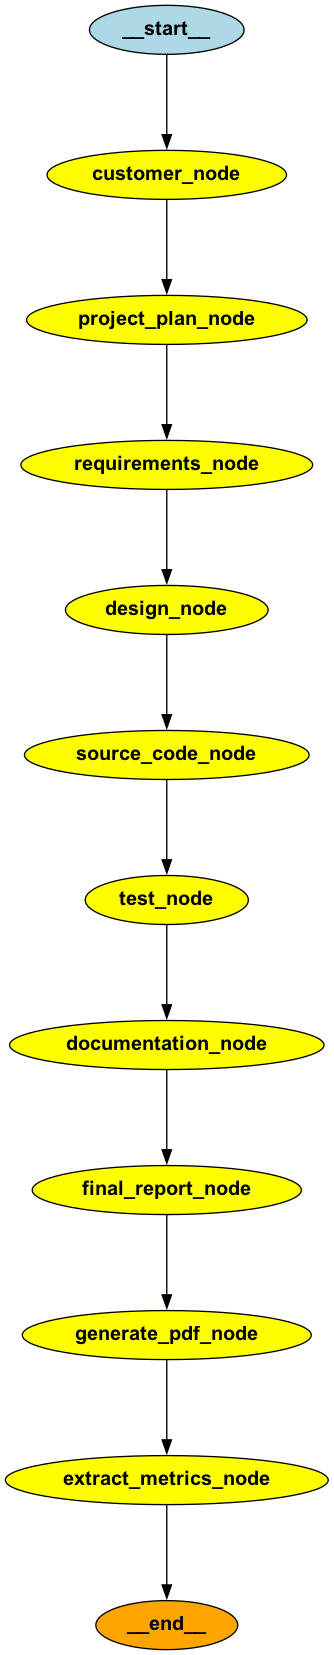

In [18]:
from IPython.display import Image
Image(graph.get_graph().draw_png())